- LSTM
- Multiple countries
- Autoregressive training

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torch.backends.cudnn as cudnn

In [55]:
# Load the CSV file
path = "data/COVID_data.csv"
df = pd.read_csv(path)  # Replace with your file path

country_waves = {"Republic of Korea": {1: [15, 123],
                                   2: [206, 295],
                                   3: [289, 436],
                                   4: [533, 652], #좀 애매함
                                   5: [736, 897],
                                   6: [897, 1010],
                                   7: [1010, 1164] #wave가 애매하게 2개임
                                   },
            "China": {1: [0, 74],
                      2: [66, 119],
                      3: [154, 266],
                      4: [316, 413], #wave가 살짝 2개에 가까움
                      5: [484, 561],
                      6: [1065, 1119],
                      },
            "United Kingdom of Great Britain and Northern Ireland": {1: [52, 184],
                                                                     2: [192, 486], #wave가 2개라서 아래의 3,4번에서 2개로 나눠도 봄.
                                                                     3: [192, 330], #2번의 앞쪽 wave
                                                                     4: [331, 486], #2번의 뒤쪽 wave
                                                                     5: [772, 871],
                                                                     6: [869, 983]
                   }
            }

using_coutries = ["Republic of Korea", "China", "United Kingdom of Great Britain and Northern Ireland"]
kind = 'New_cases' #[New_cases, Cumulative_cases, New_deaths, Cumulative_deaths]

time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
real_time_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}
wave_data = {"Republic of Korea": {}, "China": {}, "United Kingdom of Great Britain and Northern Ireland": {}}

for country in using_coutries:
    country_data = df[df["Country"] == country]
    country_data["Real_date"] = pd.to_datetime(country_data["Date_reported"]) # save the real date for plotting
    country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
    country_data["Date_reported"] = (country_data["Date_reported"] - country_data["Date_reported"].iloc[0]).dt.days
    new_cases = country_data[kind].values
    new_cases[new_cases < 1] = 1

    for wave in country_waves[country]:
        start, end = country_waves[country][wave]
        time_data[country][wave] = country_data["Date_reported"].values[start:end]
        real_time_data[country][wave] = country_data["Real_date"].values[start:end]
        wave_data[country][wave] = new_cases[start:end]

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\1896199140.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Real_date"] = pd.to_datetime(country_data["Date_reported"]) # save the real date for plotting
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\1896199140.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data["Date_reported"] = pd.to_datetime(country_data["Date_reported"])
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\1896199140.py:40: SettingWithCopyWarnin

In [56]:
# Define a function to calculate the 7-number moving average
def moving_average(data, window_size=7):
    half_window = window_size // 2
    smoothed = []
    
    for i in range(len(data)):
        # Handle edge cases
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)
        
        # Calculate the average of the current window
        smoothed.append(np.mean(data[start:end]))
    
    return smoothed

data = {} # smoothed data

for country in wave_data:
    data[country] = {}
    for wave in wave_data[country]:
        data[country][wave] = moving_average(wave_data[country][wave])

# which countries, which waves to use for training
training_coutries = ["Republic of Korea", "China"]
test_coutries = ["United Kingdom of Great Britain and Northern Ireland"]

# Model

In [57]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_dim=1):
        super(PINN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.layers = num_layers

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.1,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Shape: (batch_size, hidden_dim)
        return out

# Defining the loss functions
def MSE_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

def SIR_loss(model, t, beta, gamma, mu):
    t = t.requires_grad_(True)  # Enable gradient computation for time tensor

    # Forward pass through the model
    x = model(t)

    # Compute gradients
    dx_dt = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]  # First derivative

    # SIR model loss: dI/dt = beta * I - gamma * I
    sir_loss = dx_dt + beta * torch.exp(x) - gamma * torch.exp(x)

    # Return the squared loss
    return torch.mean(sir_loss ** 2)

In [95]:
def plot_predictions(data, test_start_point, predicted_values, date_ticks, country, epoch):
    """
    Plot predictions and training results.
    """
    # Ensure the save directory exists
    #if not os.path.exists(save_path):
    #    os.makedirs(save_path)

    data = data.cpu().numpy()

    predictions = np.append(np.array([None]*test_start_point), predicted_values)

    fig, ax1 = plt.subplots(figsize=(18, 8))
    plt.title(f"{country}. Epoch: {epoch + 1}")

    # Training Data
    ax1.plot(date_ticks, data, 'ro', markersize=8, label='Training data')

    # Predicted values
    ax1.plot(date_ticks, predictions, color="orange", label="Predicted by PINN")

    # Format x-axis
    ax1.set_xlabel("Date")
    ax1.set_ylabel("I(t)", color="k")
    ax1.tick_params(axis='y', labelcolor="k")
    ax1.legend(loc="upper left")
    ax1.grid()

    # Set date ticks
    tick_labels = np.array(date_ticks[:len(data[::7])])
    ax1.set_xticks(np.array(date_ticks[::7].flatten())) # 없어도 될 것 같음
    ax1.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor")

    # Plotting
    plt.tight_layout()
    plt.show()
    plt.close()

In [58]:
class EarlyStopping:
    def __init__(self, model, patience, display_step, sigma, sigma0, mu):
        self.patience = patience
        self.display_step = display_step
        self.model = model
        self.sigma = sigma
        self.sigma0 = sigma0
        self.mu = mu
        
        self.best_loss = np.inf
        self.wait = 0

        self.best_model = None
        self.bests_weights = None
        self.bestSigma = None
        self.bestSigma0 = None
        self.bestMu = None

    def check_early_stopping(self, current_loss, epoch):
        if current_loss < self.best_loss:
            self.best_loss = current_loss.cpu().item() if torch.is_tensor(current_loss) else current_loss
            self.wait = 0

            self.best_model = self.model
            self.best_weights = self.model.state_dict()
            self.bestSigma = self.sigma
            self.bestSigma0 = self.sigma0
            self.bestMu = self.mu
        else:
            self.wait += 1
        
        if self.wait >= self.patience:
            print(f"Early stopping at epoch {epoch}.")
            self.model.load_state_dict(self.best_weights)
            return True
        return False

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Training

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 1, MSE Loss = 0.0006156282033771276, SIR Loss = 1.2202279187079057e-08, Average Loss = 0.047595541398493986


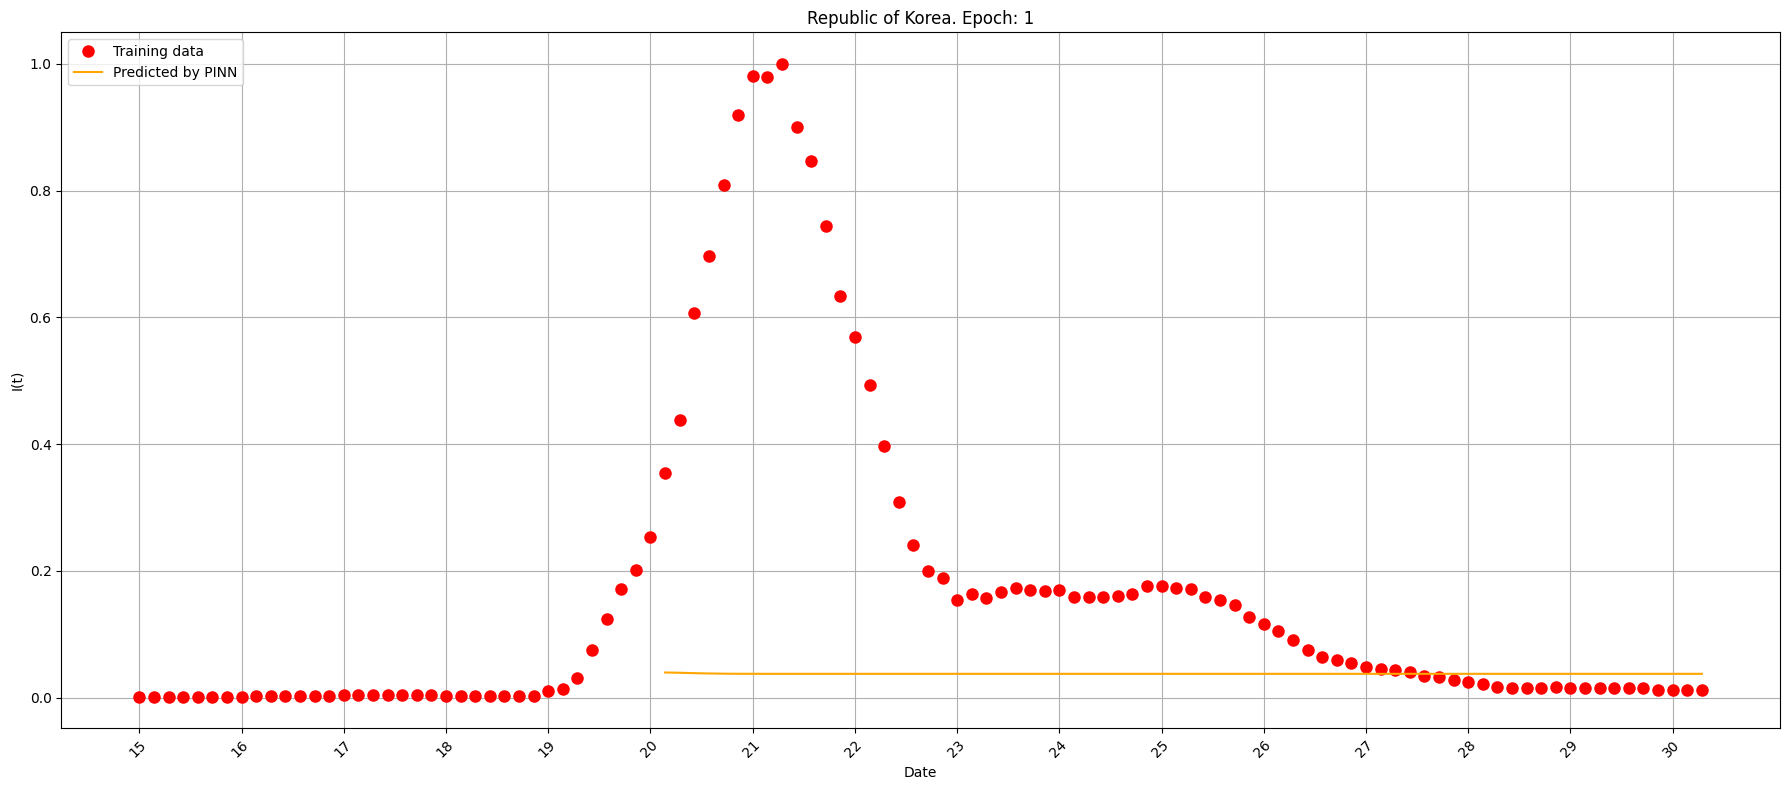

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Epoch 101, MSE Loss = 0.00015029449423309416, SIR Loss = 1.2956125949870057e-08, Average Loss = 0.0008437628289027993


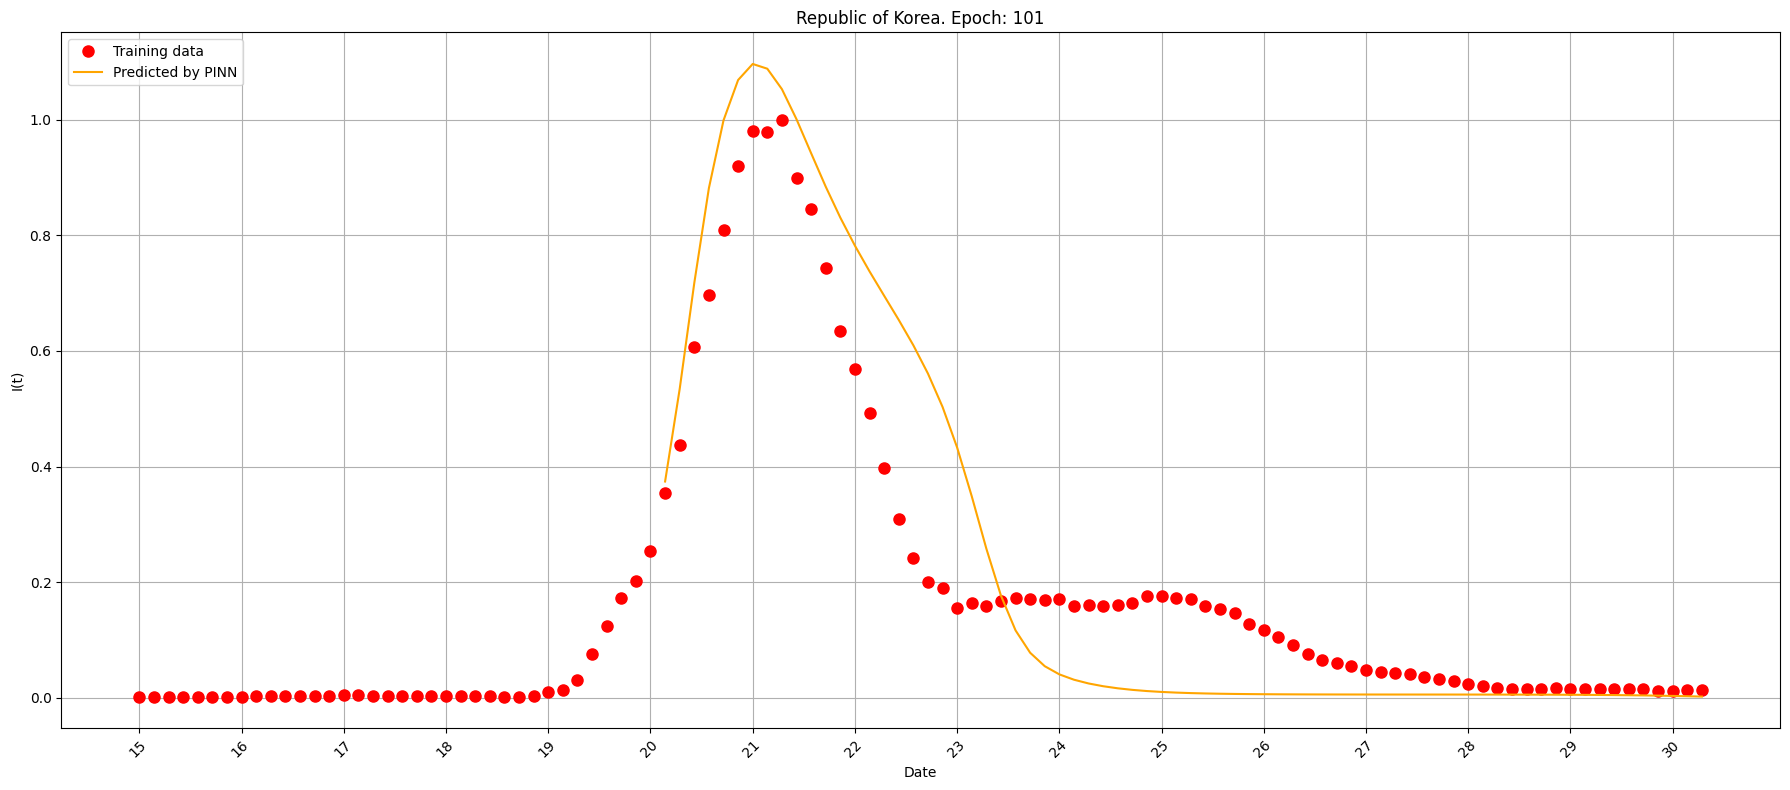

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Early stopping at epoch 168.
Epoch 1, MSE Loss = 0.00047381874173879623, SIR Loss = 4.2620639656432147e-11, Average Loss = 0.004764373462383887


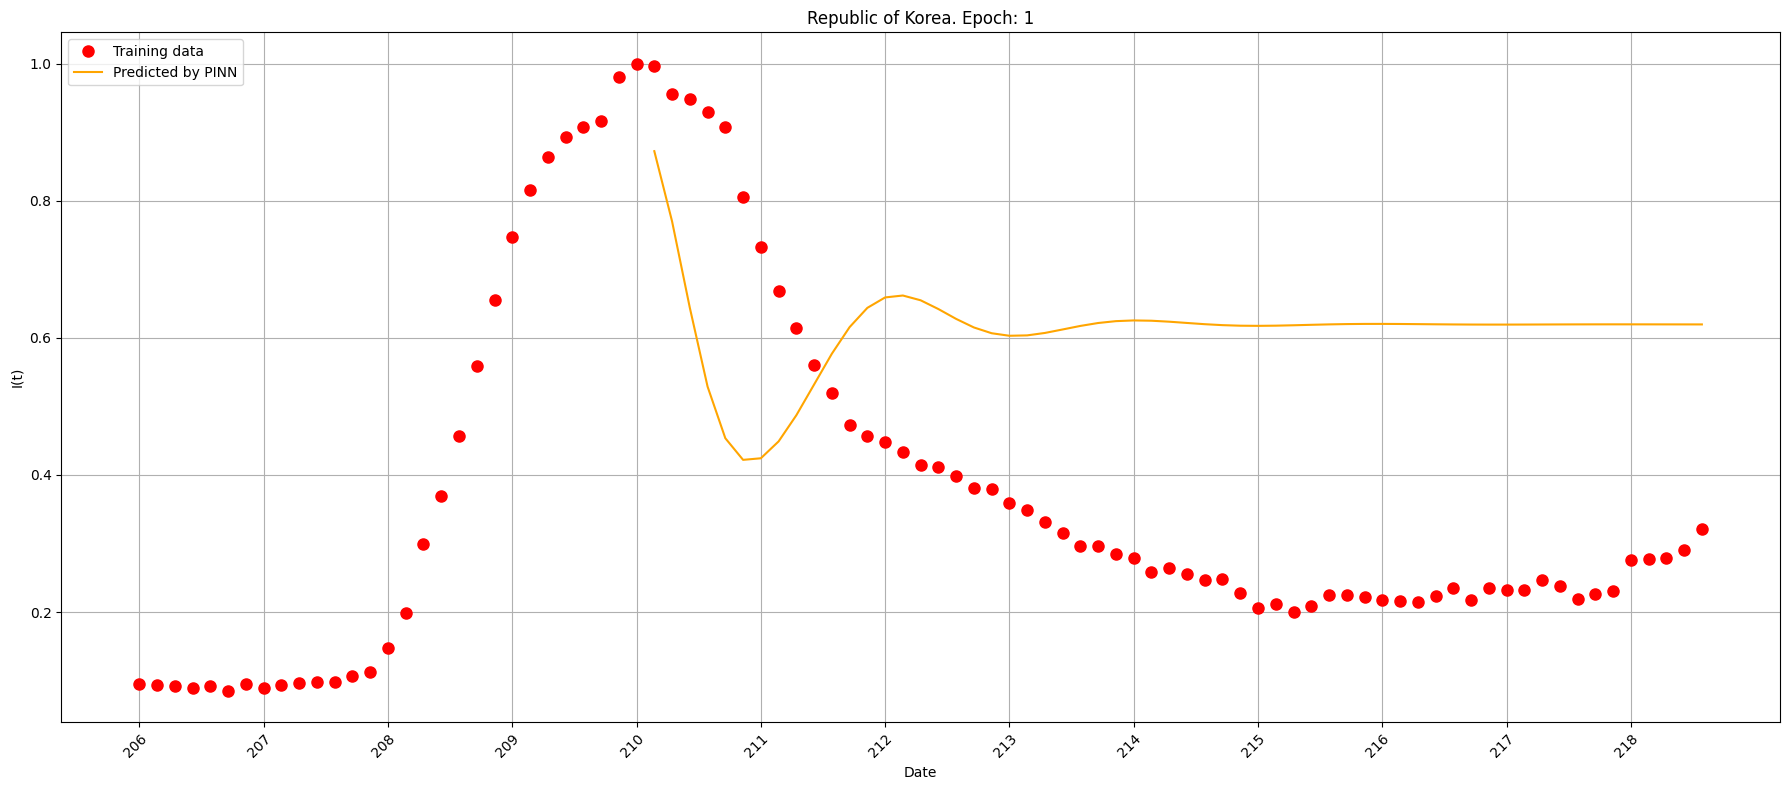

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Early stopping at epoch 69.
Epoch 1, MSE Loss = 0.000336030701873824, SIR Loss = 2.845392366168653e-09, Average Loss = 0.0009952032790846285


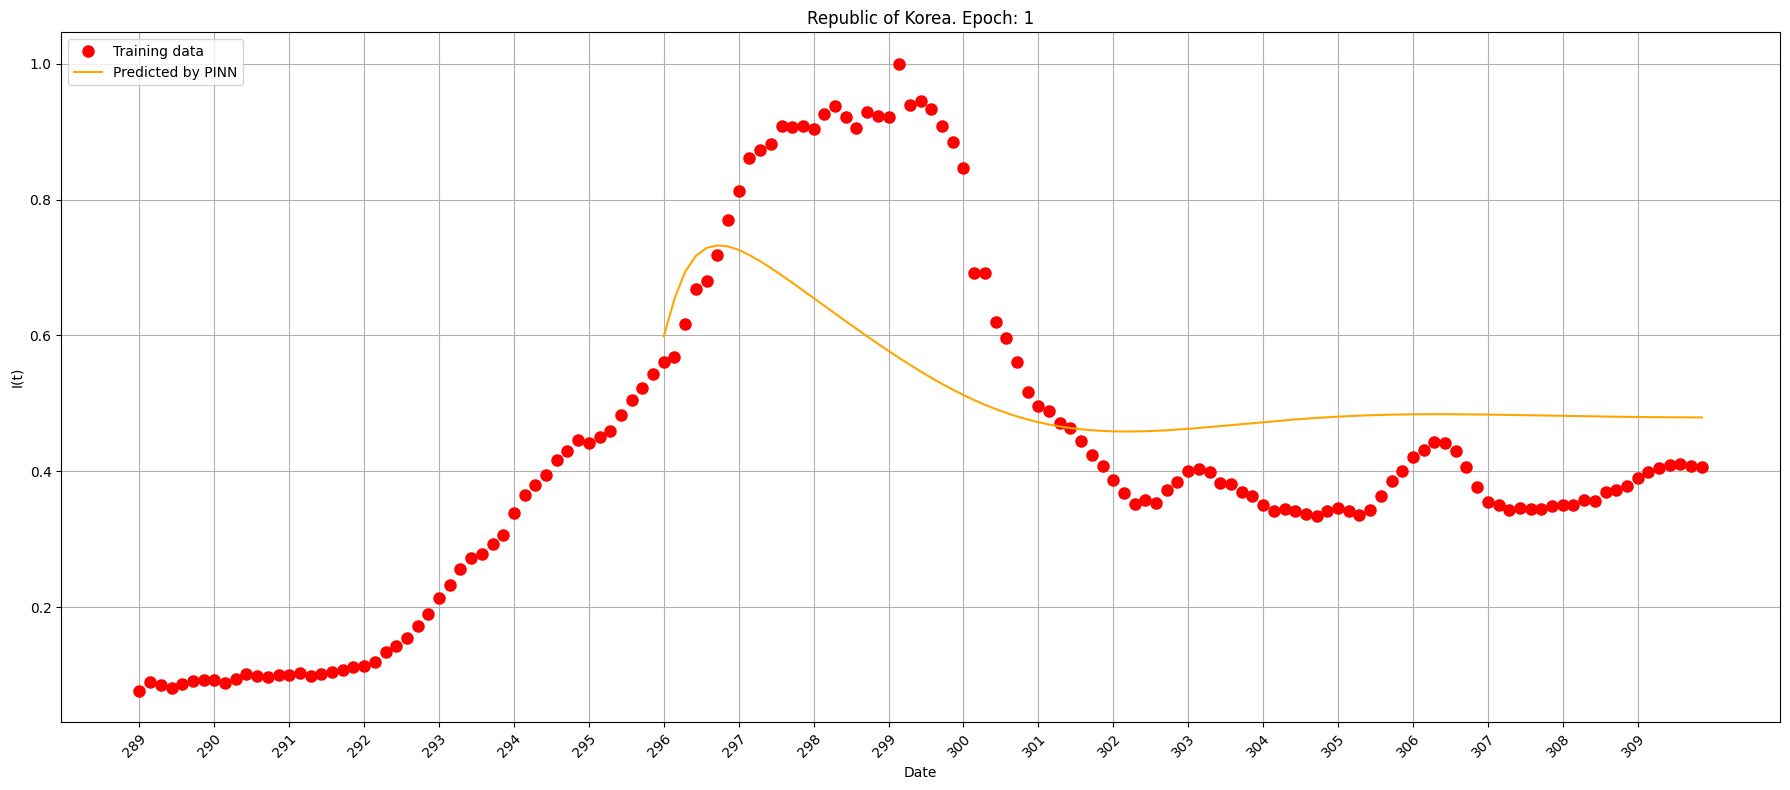

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


Early stopping at epoch 99.
Epoch 1, MSE Loss = 0.00025219106464646757, SIR Loss = 0.0, Average Loss = 0.002125670849943473


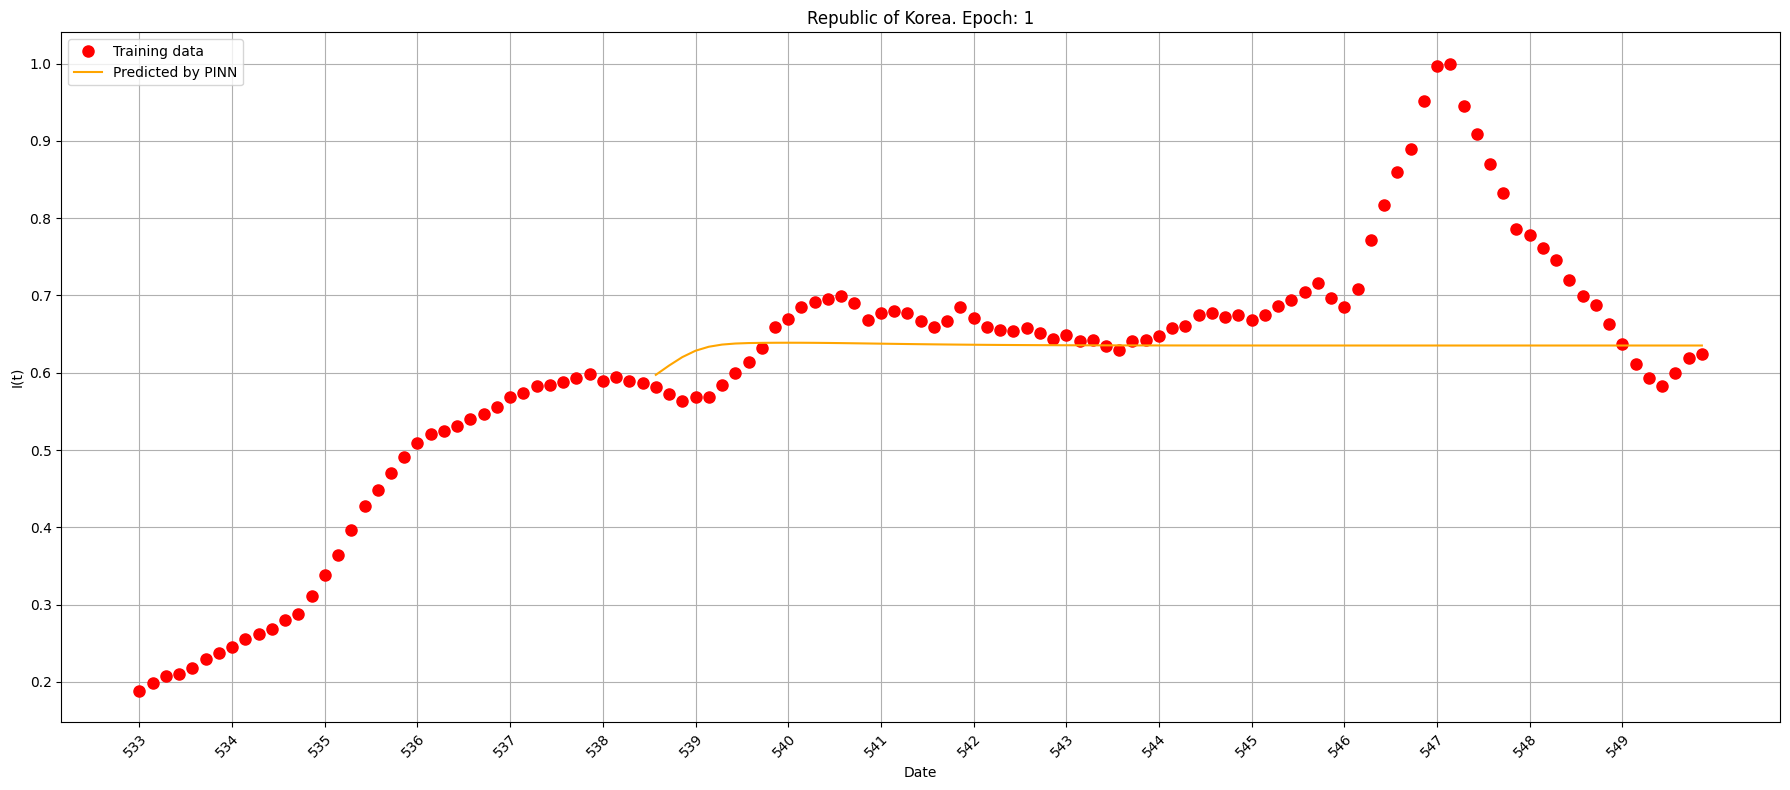

C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Lunosoft\AppData\Local\Temp\ipykernel_13860\3791028123.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)


KeyboardInterrupt: 

In [96]:
#autoregressive training version
def train_autoregressive(model, optimizer, data, t_data, real_t, sigma, sigma0, mu, epochs, patience, display_step, date_ticks, country):
    """
    Train the model using autoregressive learning.
    
    Parameters:
        model: PINN model
        optimizer: Optimizer
        data: data for training
        t_data: time sequence for SIR loss (1,2,3,...)
        real_t: real time sequence for plotting (Date Time)
        sigma, sigma0, mu: SIR model parameters
        epochs: Total epochs
        patience: Early stopping patience
        display_step: Steps to visualize predictions
        date_ticks: Time labels for plots
        country: Country name for visualization
    """
    early_stopping = EarlyStopping(model, patience, display_step, sigma, sigma0, mu)
    losses = []

    # Number of autoregressive steps (how far ahead to predict at each iteration)
    start_point = 7  # Predict after week ahead

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        total_loss = 0.0

        input_sequence = data[:start_point]
        input_t_sequence = t_data[:start_point]

        input_sequence = list(input_sequence)

        for i in range(start_point, len(data)):
            input_t = torch.tensor(input_t_sequence, dtype=torch.float32).view(-1, 1).to(device)
            input_tensor = torch.tensor(input_sequence, dtype=torch.float32).view(-1, 1).to(device)
            target = torch.tensor(data[i], dtype=torch.float32).view(-1, 1).to(device)

            with torch.backends.cudnn.flags(enabled=False):
                # Forward pass
                predicted = model(input_tensor)
                mse_loss = MSE_loss(target, predicted)
                sir_loss = SIR_loss(model, input_t, sigma, sigma0, mu)
                # Combine losses
                loss = mse_loss + sir_loss
                loss.backward()
                optimizer.step()
                optimizer.zero_grad() # Clear gradients

            total_loss += loss.item()

            input_sequence.append(data[i])

        avg_loss = total_loss / (len(data) - start_point)
        losses.append(avg_loss)

        test_start_point = int(len(data) / 3)

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}, MSE Loss = {mse_loss.item()}, SIR Loss = {sir_loss.item()}, Average Loss = {avg_loss}")

        if epoch % display_step == 0:
            with torch.no_grad():
                predicted_values = autoregressive_predict(model, data[:test_start_point], len(data) - test_start_point, delta_t=1)
                # Ensure dimensions match for plotting
                predicted_values = predicted_values[:len(data) - start_point]  # Slice to match y_data
                plot_predictions(
                    data,
                    test_start_point,
                    predicted_values=predicted_values,
                    date_ticks=date_ticks,
                    country=country,
                    epoch=epoch,
                )

        if early_stopping.check_early_stopping(avg_loss, epoch):
            break

    return losses

def autoregressive_predict(model, given_data, steps, delta_t):
    """
    Predict future values in an autoregressive manner with multi-step outputs.
    
    Parameters:
        model: Trained PINN model
        data: data for prediction test
        steps: Number of future steps to predict
        delta_t: Step size for time
    
    Returns:
        Predicted values (list)
    """
    model.eval()
    input_sequence = list(given_data)
    predictions = torch.tensor([])

    with torch.no_grad():
        for _ in range(steps):
            input_tensor = torch.tensor(input_sequence, dtype=torch.float32).view(-1, 1).to(device)
            predicted = model(input_tensor).squeeze()
            predictions = np.append(predictions, predicted.cpu().numpy())
            input_sequence.append(predicted)
    
    return predictions

# Initialize parameters
sigma = torch.tensor([0.1], requires_grad=True).to(device)
sigma0 = torch.tensor([0.1], requires_grad=True).to(device)
mu = torch.tensor([0.1], requires_grad=True).to(device)

# Initialize the model and optimizer
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model using autoregressive learning
for country in training_coutries:
    for wave in data[country]:
        t_data = torch.tensor(time_data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
        y_data = torch.tensor(data[country][wave], dtype=torch.float32).view(-1, 1).to(device)
        real_t = real_time_data[country][wave] # Real time data for plotting

        t_train = t_data
        y_train = y_data / max(y_data)  # Normalize data

        losses = train_autoregressive(
            model=model,
            optimizer=optimizer,
            data=y_train,
            t_data=t_train,
            real_t=real_t,
            sigma=sigma,
            sigma0=sigma0,
            mu=mu,
            epochs=200,
            patience=50,
            display_step=100,
            date_ticks=time_data[country][wave],
            country=country
        )

        # Save the model for this wave
        torch.save(model.state_dict(), f"models/{country}_wave_{wave}_ar.pt")